# Training totals

This notebook explores my training for DJBB 2024 in Jamaica.

## Setup imports

In [51]:
import os, sys
import tempfile
import logging

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%aimport utils
%autoreload 1

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 100)

In [52]:
# log level
logging.basicConfig(
    stream=sys.stdout,
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.WARNING)

# disable font not found warnings
logging.getLogger('matplotlib.font_manager').disabled = True

## Setup data directory

In [53]:
# Use Jupyter magic to retain variable in this notebook
%env DATA_DIRECTORY=data
dataset_name = "my_activity_data=20240508102713.csv"
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = os.path.join(root_dir, dataset_name)
print(f"Data root: {root_dir}, file: {data_dir}")

env: DATA_DIRECTORY=data
Data root: data, file: data/my_activity_data=20240508102713.csv


In [54]:
df = pd.read_csv(data_dir, parse_dates=['start_date', 'start_date_local'])

# Initial data exploration
Let's familiarize with Strava data dump.

In [55]:
df.shape

(149, 60)

In [56]:
df.columns

Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'average_cadence', 'average_watts', 'max_watts',
       'weighted_average_watts', 'kilojoules', 'device_watts', 'has_heartrate',
       'average_heartrate', 'max_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'suffer_score', 'athlete.id',
       'athlete.resource_state', 'map.id', 'map.sum

In [57]:
df.type.unique()

array(['Run', 'Ride', 'Swim', 'Walk', 'Workout', 'VirtualRide',
       'WeightTraining'], dtype=object)

In [58]:
df.sport_type.unique()

array(['Run', 'Ride', 'Swim', 'Walk', 'Workout', 'VirtualRide',
       'WeightTraining'], dtype=object)

In [59]:
df.suffer_score.describe()

count    129.000000
mean      47.201550
std       49.000698
min        0.000000
25%        6.000000
50%       29.000000
75%       71.000000
max      181.000000
Name: suffer_score, dtype: float64

In [60]:
df.timezone.unique()

array(['(GMT-05:00) America/Jamaica', '(GMT+02:00) Europe/Helsinki',
       '(GMT+02:00) Africa/Blantyre', '(GMT+03:00) Africa/Addis_Ababa',
       '(GMT+00:00) Africa/Abidjan', '(GMT+00:00) GMT0',
       '(GMT+00:00) America/Danmarkshavn', '(GMT+00:00) GMT',
       '(GMT+00:00) Greenwich', '(GMT+00:00) UTC',
       '(GMT-01:00) America/Scoresbysund', '(GMT+02:00) Asia/Famagusta'],
      dtype=object)

In [61]:
df.location_city.unique()

array([nan])

In [62]:
df.location_country.unique()

array(['Jamaica', 'Finland'], dtype=object)

In [63]:
df.utc_offset.unique()/3600

array([-5.,  2.,  3.,  0.])

In [64]:
zones = ['(GMT+02:00) Africa/Blantyre', '(GMT+03:00) Africa/Addis_Ababa',\
'(GMT+00:00) Africa/Abidjan', '(GMT+00:00) GMT0',\
'(GMT+00:00) America/Danmarkshavn', '(GMT+00:00) GMT',\
'(GMT+00:00) Greenwich', '(GMT+00:00) UTC',\
'(GMT-01:00) America/Scoresbysund', '(GMT+02:00) Asia/Famagusta']

for z in zones:
    for index, row in df.loc[df.timezone == z].iterrows():
        print("{}: {} in {} on {}".format(
            index, row.sport_type, row.location_country, row.start_date_local)
            )

99: Ride in Finland on 2024-01-25 19:31:56+00:00
100: Ride in Finland on 2024-01-25 18:47:33+00:00
115: Swim in Finland on 2024-01-04 11:16:02+00:00
123: Swim in Finland on 2023-05-06 11:09:41+00:00
128: WeightTraining in Finland on 2022-10-04 06:12:22+00:00
130: WeightTraining in Finland on 2022-09-28 06:12:01+00:00
131: WeightTraining in Finland on 2022-09-26 06:37:56+00:00
133: WeightTraining in Finland on 2022-09-23 13:56:47+00:00
137: WeightTraining in Finland on 2022-09-07 07:41:25+00:00
134: WeightTraining in Finland on 2022-09-20 13:23:33+00:00
135: WeightTraining in Finland on 2022-09-13 11:05:57+00:00
141: WeightTraining in Finland on 2022-08-25 15:01:11+00:00
144: WeightTraining in Finland on 2022-08-16 16:24:44+00:00
145: Swim in Finland on 2022-08-14 12:18:18+00:00


In [65]:
for i in [99, 100, 115, 123]:
    print(df.loc[i].timezone)

(GMT+02:00) Africa/Blantyre
(GMT+02:00) Africa/Blantyre
(GMT+02:00) Africa/Blantyre
(GMT+03:00) Africa/Addis_Ababa


NOTE, looks like these have just wrong timezone string. Index 123 has summer time too.

In [66]:
df.loc[df.location_country == 'Finland'].head()

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,id,...,pr_count,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_temp
61,2,Morning Run,5253.5,2123,2211,42.1,Run,Run,0.0,10915643273,...,0,0,False,36.0,104560661,1,a10915643273,_iamBn_wsMJZB\Jb@`@|@b@t@Pj@`@rB?ZAZLDVAjBBFBL...,2,NaN
62,2,Morning Ride,30093.8,7768,9966,689.0,Ride,Ride,10.0,10909207443,...,0,3,False,53.0,104560661,1,a10909207443,ejbmBvausM{@jC[J{DoA{BwAMa@v@kCPgD}@OoA|@i@?oH...,2,19.0
63,2,Morning Ride,2272.1,442,468,34.0,Ride,Ride,NaN,10908205344,...,0,0,False,3.0,104560661,1,a10908205344,klamBrjvsMtAgArAwA|@y@fAk@b@Mt@Gf@B|@NzCv@j@JH...,2,23.0
64,2,Afternoon Walk,5839.1,4911,5396,83.2,Walk,Walk,NaN,10905815315,...,0,0,False,12.0,104560661,1,a10905815315,kebmBtfvsMFGOI?EGQICSUOBCMIGY@KAAA_@?IEAGo@YIM...,2,NaN
65,2,Afternoon Workout,0.0,5953,5953,0.0,Workout,Workout,NaN,10895075943,...,0,0,False,29.0,104560661,1,a10895075943,NaN,2,NaN


In [67]:
df.has_heartrate.describe()

count      149
unique       2
top       True
freq       125
Name: has_heartrate, dtype: object

In [68]:
df.average_heartrate.describe()

count    125.000000
mean     120.892000
std       19.181399
min       78.600000
25%      106.800000
50%      121.400000
75%      138.400000
max      151.300000
Name: average_heartrate, dtype: float64

TODO looks like we could manually assign training zone for an exercise.

## Analyze data

### Finland pre-training

In [69]:
# 2024 pre-training in Finland, during winter, make a copy(!)
df_fin = df.loc[
    (df.location_country == "Finland")
    & (df.start_date >= "2024-01-01")
    & (df.start_date <= "2024-02-14")
].copy()

# Fix timezone attribute
df_fin["start_date_local"] = (
    df_fin["start_date_local"].dt.tz_localize(None).dt.tz_localize("Europe/Helsinki")
)

In [70]:
df_fin.sport_type.unique()

array(['VirtualRide', 'Workout', 'Walk', 'WeightTraining', 'Ride', 'Swim'],
      dtype=object)

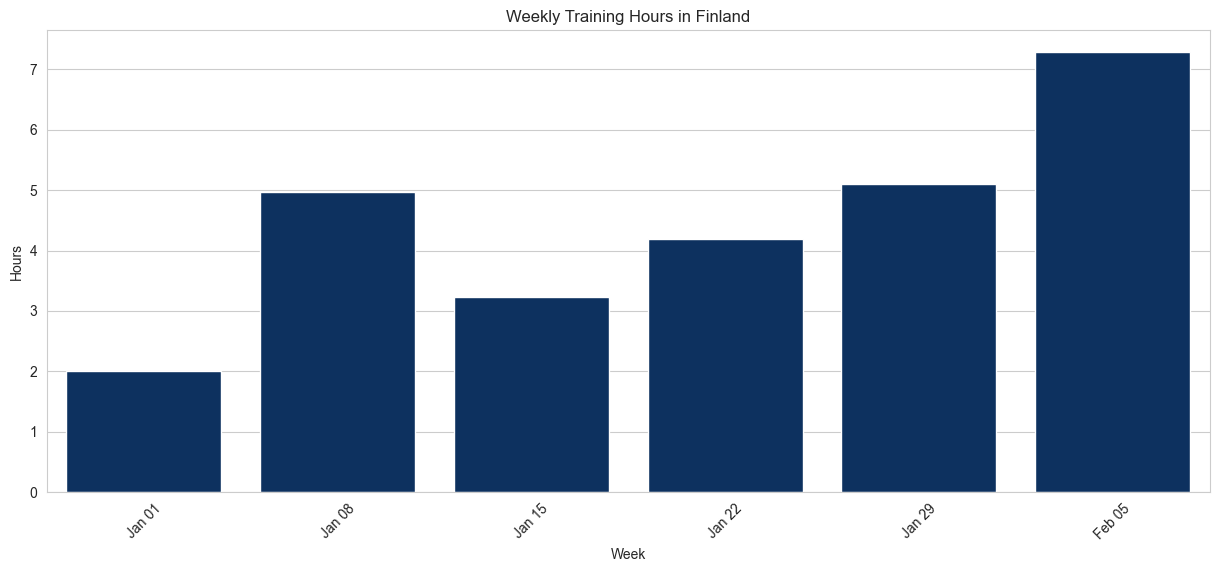

In [71]:
df_fin_weekly = (
    df_fin.groupby(
        pd.Grouper(key="start_date_local", freq="W-MON", label="left")
    ).moving_time.sum()
    / 3600
)
df_weekly = df_fin_weekly.reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(
    #x=df_fin_weekly["start_date_local"].dt.strftime("W%U"),
    x=df_weekly["start_date_local"].dt.strftime("%b %d"),
    y=df_weekly["moving_time"],
    color=utils.colors["Finland flag blue"],
)

plt.title("Weekly Training Hours in Finland")
plt.ylabel("Hours")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.show()

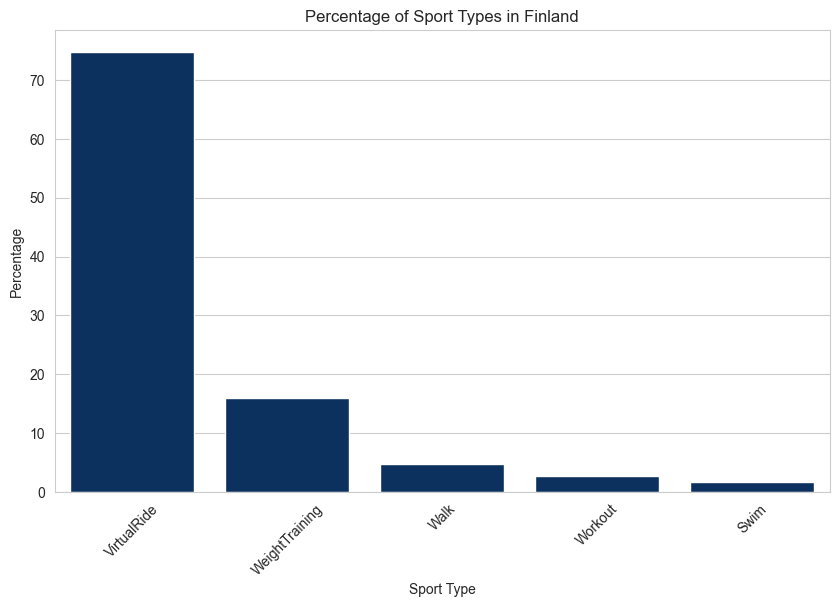

In [72]:
# Group Ride and VirtualRide as VirtualRide
moving_time_by_type = df_fin.groupby(
    df_fin["type"].replace({"Ride": "VirtualRide"})
).moving_time.sum().sort_values(ascending=False)
percentages = (moving_time_by_type / moving_time_by_type.sum()) * 100

# Plot the percentages as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=percentages.index,
    y=percentages.values,
    color=utils.colors["Finland flag blue"],
)
plt.title("Percentage of Sport Types in Finland")
plt.ylabel("Percentage")
plt.xlabel("Sport Type")
plt.xticks(rotation=45)
plt.show()

In [73]:
# pre-training hours per sport type
moving_time_by_type / 3600

type
VirtualRide       20.003611
WeightTraining     4.279444
Walk               1.295278
Workout            0.741944
Swim               0.451667
Name: moving_time, dtype: float64

In [74]:
# average weekly training hours
df_fin_weekly.mean()

np.float64(4.461990740740741)

### Training in Jamaica

In [75]:
# let's take shorted time span

df_jam = df.loc[(df.start_date > "2024-02-14") & (df.start_date <= "2024-03-20")].copy()
df_jam.timezone.unique()

array(['(GMT-05:00) America/Jamaica', '(GMT+02:00) Europe/Helsinki'],
      dtype=object)

In [76]:
# When I arrived to Jamaica, I forgot to set country and timezone to Jamaica in Strava, need to fix it here.
df_jam.replace(
    {
        "location_country": {"Finland": "Jamaica"},
        "timezone": {"(GMT+02:00) Europe/Helsinki": "(GMT-05:00) America/Jamaica"},
    },
    inplace=True,
)
df_jam.location_country.unique()

array(['Jamaica'], dtype=object)

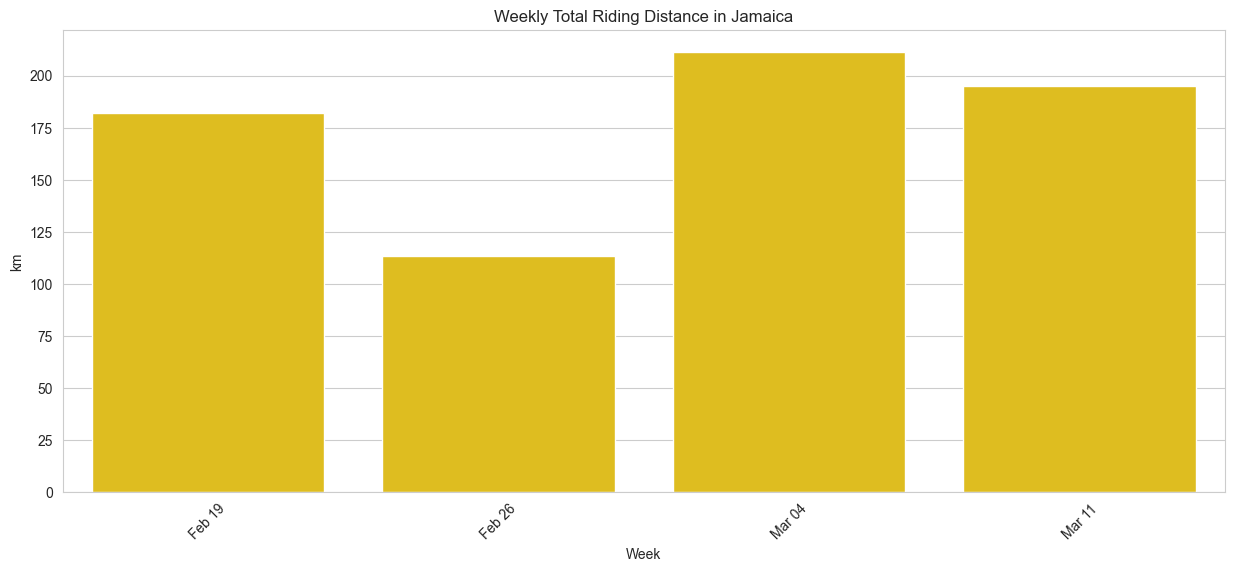

In [77]:
df_jam_weekly = (
    df_jam[df_jam["type"] == "Ride"].groupby(
        pd.Grouper(key="start_date_local", freq="W-MON", label="left")
    ).distance.sum()
    / 1000
)
df_weekly = df_jam_weekly.reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(
    #x=df_fin_weekly["start_date_local"].dt.strftime("W%U"),
    x=df_weekly["start_date_local"].dt.strftime("%b %d"),
    y=df_weekly["distance"],
    color=utils.colors["Jamaica flag yellow"]
)

plt.title("Weekly Total Riding Distance in Jamaica")
plt.ylabel("km")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.show()

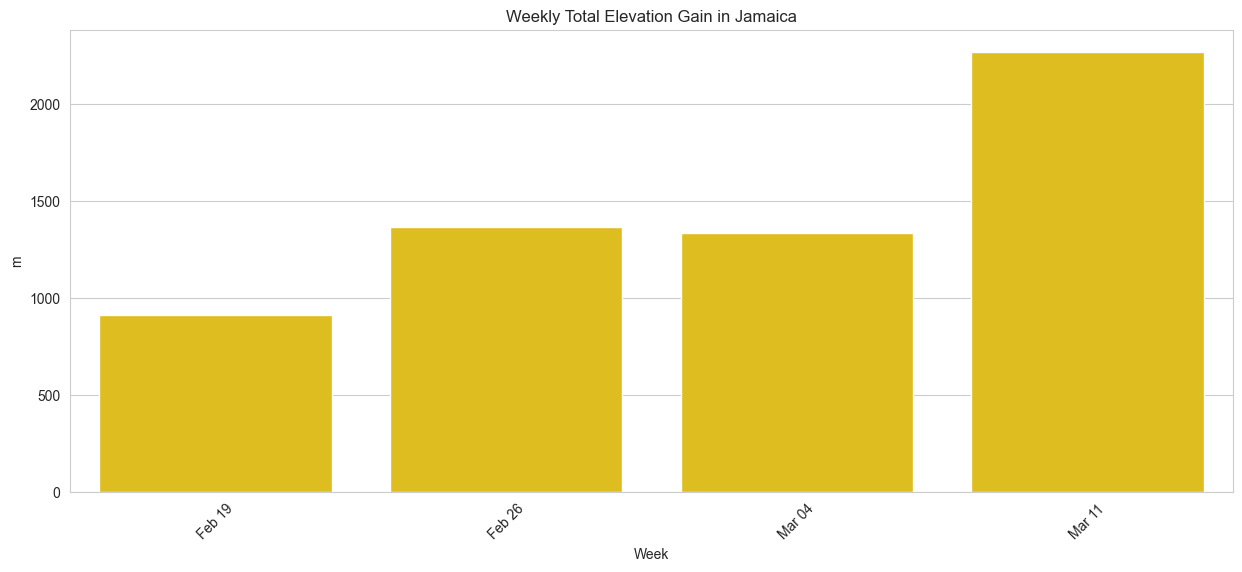

In [78]:
df_jam_weekly = (
    df_jam[df_jam["type"] == "Ride"].groupby(
        pd.Grouper(key="start_date_local", freq="W-MON", label="left")
    ).total_elevation_gain.sum()
)
df_weekly = df_jam_weekly.reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(
    #x=df_fin_weekly["start_date_local"].dt.strftime("W%U"),
    x=df_weekly["start_date_local"].dt.strftime("%b %d"),
    y=df_weekly["total_elevation_gain"],
    color=utils.colors["Jamaica flag yellow"]
)

plt.title("Weekly Total Elevation Gain in Jamaica")
plt.ylabel("m")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.show()

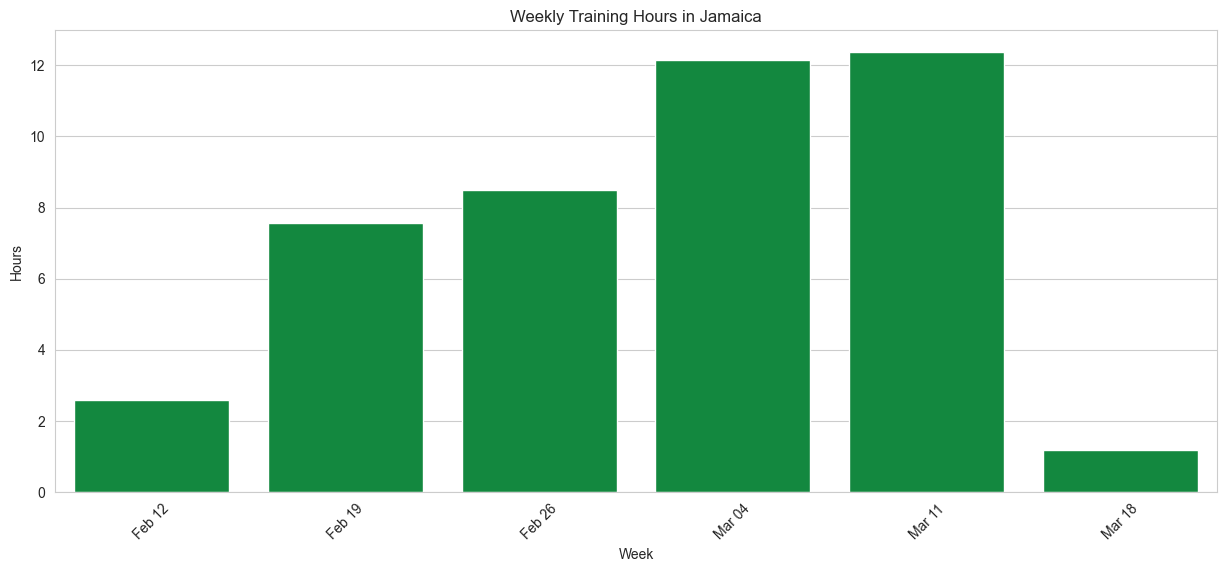

In [79]:
df_jam_weekly = (
    df_jam.groupby(
        pd.Grouper(key="start_date_local", freq="W-MON", label="left")
    ).moving_time.sum()
    / 3600
)
df_weekly = df_jam_weekly.reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(    
    x=df_weekly["start_date_local"].dt.strftime("%b %d"),
    y=df_weekly["moving_time"],
    color=utils.colors["Jamaica flag green"]
)

plt.title("Weekly Training Hours in Jamaica")
plt.ylabel("Hours")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.show()

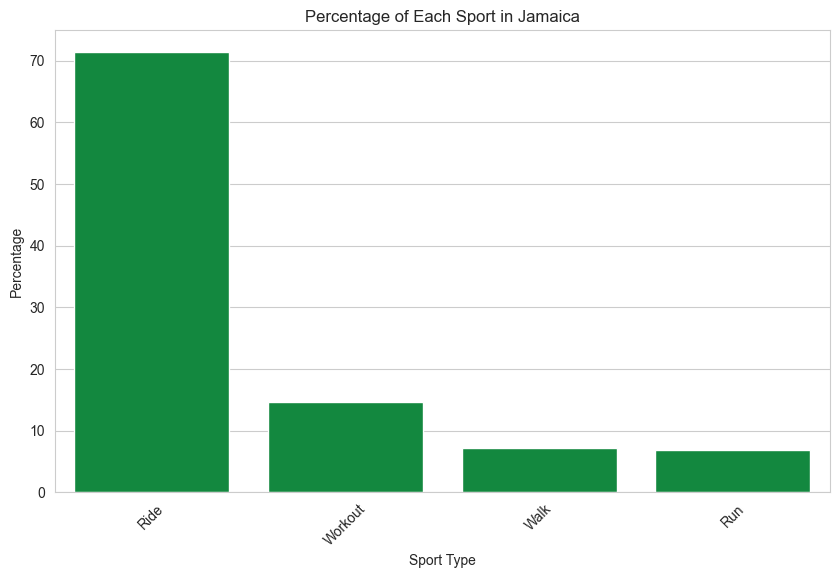

In [80]:
moving_time_by_type = df_jam.groupby("type").moving_time.sum().sort_values(ascending=False)
percentages = (moving_time_by_type / moving_time_by_type.sum()) * 100

# Plot the percentages as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=percentages.index,
    y=percentages.values,
    color=utils.colors["Jamaica flag green"],
)
plt.title("Percentage of Each Sport in Jamaica")
plt.ylabel("Percentage")
plt.xlabel("Sport Type")
plt.xticks(rotation=45)
plt.show()

### About training load
I had very little training in Fall 2024, but started to ramp up amounts quickly in beginning of 2024.

In [81]:
df_load = df.loc[
    (df.start_date >= "2024-01-01")
    & (df.start_date <= "2024-03-20")
].copy()

df_weekly = (
    df_load.groupby(
        pd.Grouper(key="start_date_local", freq="W-MON", label="left")
    ).agg({"moving_time": "sum", "suffer_score": "max"})
).reset_index()

df_weekly["moving_time"] = df_weekly["moving_time"] / 3600
df_weekly.head(10)

,start_date_local,moving_time,suffer_score
0,2024-01-01 00:00:00+00:00,2.010833,60.0
1,2024-01-08 00:00:00+00:00,4.961389,76.0
2,2024-01-15 00:00:00+00:00,3.238333,44.0
3,2024-01-22 00:00:00+00:00,4.190556,76.0
4,2024-01-29 00:00:00+00:00,5.092778,82.0
5,2024-02-05 00:00:00+00:00,7.278056,164.0
6,2024-02-12 00:00:00+00:00,2.581389,60.0
7,2024-02-19 00:00:00+00:00,7.563056,137.0
8,2024-02-26 00:00:00+00:00,8.494167,90.0
9,2024-03-04 00:00:00+00:00,12.146389,142.0


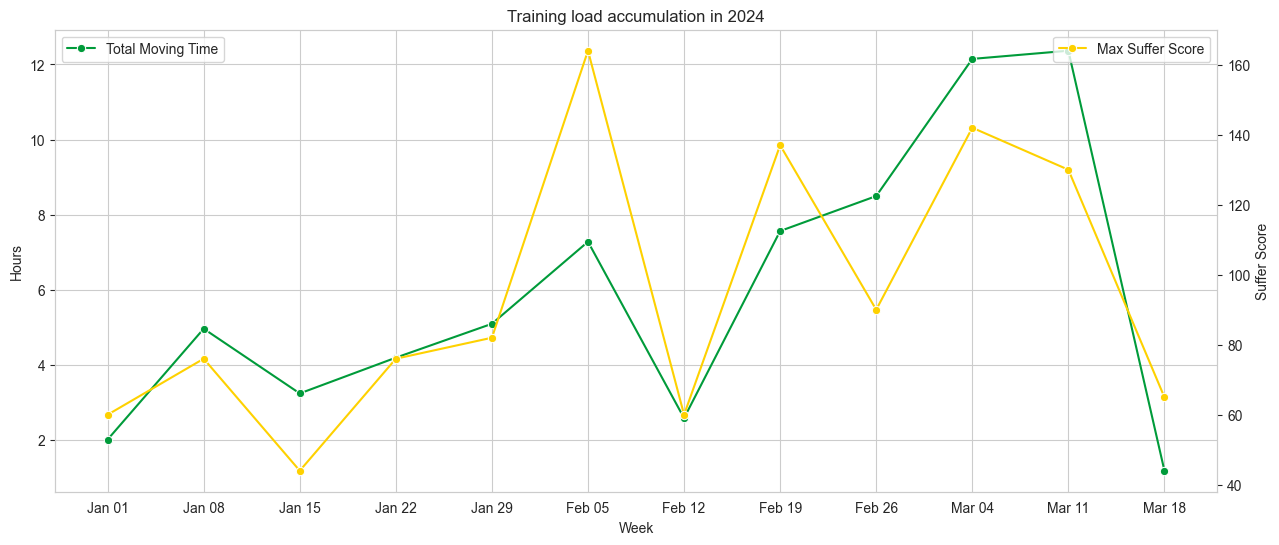

In [82]:

# Create a bar plot using Seaborn
fig, ax1 = plt.subplots(figsize=(15, 6))

sns.lineplot(    
    x=df_weekly["start_date_local"].dt.strftime("%b %d"),
    y=df_weekly["moving_time"],
    marker='o',
    color=utils.colors["Jamaica flag green"],
    label='Total Moving Time',
    ax=ax1
)
ax1.set_ylabel("Hours")
ax1.set_xlabel("Week")

ax2 = ax1.twinx()
sns.lineplot(    
    x=df_weekly["start_date_local"].dt.strftime("%b %d"),
    y=df_weekly["suffer_score"],
    marker='o',
    color=utils.colors["Jamaica flag yellow"],
    label='Max Suffer Score',
    ax=ax2
)
ax2.grid(False)
ax2.set_ylabel("Suffer Score")
ax2.set_xlabel("Week")

plt.title("Training load accumulation in 2024")
plt.xticks(rotation=45)
plt.show()


## DJBB2024 statistics

TBD

- remember one day had crazy data
- what could be interesting for people?